# Packages

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt


## TensorFlow Packages (Basics)

In [13]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Set Up

In [7]:
data_dir = r"C:\Users\gdlar\Downloads\Files\Binary_Split\Data"
batch_size = 32; #standard batch size, can change as we move along
img_height = 150; #may need to change based on model used (alter at model generation?)
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
) 

Found 76391 files belonging to 2 classes.
Using 61113 files for training.
Found 76391 files belonging to 2 classes.
Using 15278 files for validation.


In [8]:
train_ds

<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>

In [9]:
size = (224, 224)

train_ds_res1 = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds_res1 = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

## Data Augmentation

In [28]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.Sequential(
    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.1)
    ]
)
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [29]:
aug_ds1 = aug_ds.map(lambda x, y: (tf.image.resize(x, size), y))

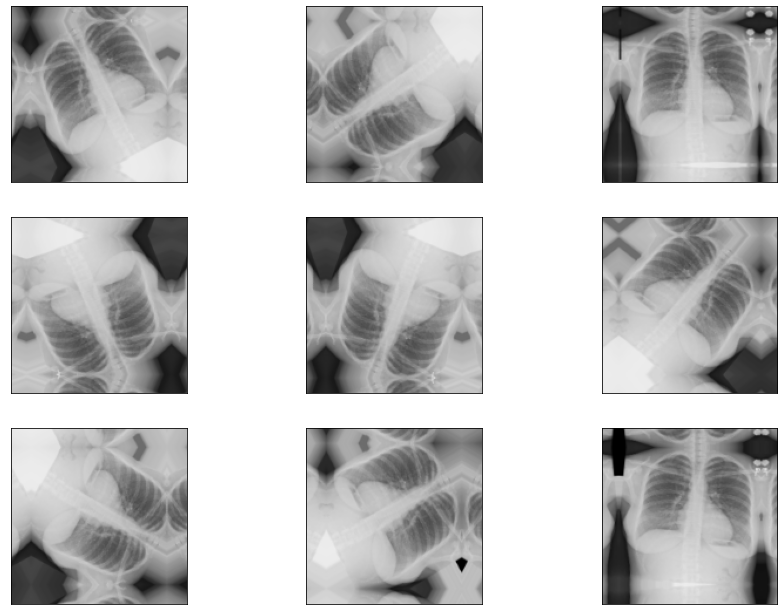

In [17]:
data_augmentation =Sequential()
# data_augmentation.add(layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)))
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))
data_augmentation.add(layers.RandomRotation(0.2,fill_mode='nearest'))
# data_augmentation.add(layers.RandomRotation(0.2))
data_augmentation.add(layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')) 


plt.figure(figsize=[15,11])
for image, label in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(image) 
        plt.subplot(3, 3, i + 1, xticks=[],yticks=[])
        plt.imshow(augmented_images[0].numpy().astype("uint8"))        
plt.show()

aug_ds_2 = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

aug_ds_res2 = aug_ds_2.map(lambda x, y: (tf.image.resize(x, size), y))

# Modeling

In [22]:
metrics = ['AUC', 'accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TrueNegatives']

# Resnet 50

## Model 1

In [18]:
keras.backend.clear_session()

In [19]:
base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', pooling = 'max')

In [20]:
model = tf.keras.Sequential()
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
model.add(base_model)
model.add(Dense(512, activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [21]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001) # around 30%
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) # around 34%
# optimizer = tf.keras.optimizers.Adadelta() # around 37%
# optimizer = tf.keras.optimizers.RMSprop() # around 40%
# optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=0.001) # around 50%



model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'FalseNegatives', 'TrueNegatives'])

model.fit(train_ds_res1, validation_data = validation_ds_res1, 
                  steps_per_epoch = 50, 
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 42s 671ms/step - loss: 0.6931 - auc: 0.5305 - accuracy: 0.5013 - precision: 0.6250 - recall: 0.1474 - false_negatives: 723.0000 - true_negatives: 677.0000 - val_loss: 0.6933 - val_auc: 0.5074 - val_accuracy: 0.4975 - val_precision: 0.5679 - val_recall: 0.2032 - val_false_negatives: 6429.0000 - val_true_negatives: 5961.0000
Epoch 2/5
50/50 [==============================] - 32s 646ms/step - loss: 0.6933 - auc: 0.5010 - accuracy: 0.4856 - precision: 0.5582 - recall: 0.2695 - false_negatives: 637.0000 - true_negatives: 542.0000 - val_loss: 0.6931 - val_auc: 0.5067 - val_accuracy: 0.5109 - val_precision: 0.5513 - val_recall: 0.3971 - val_false_negatives: 4865.0000 - val_true_negatives: 4601.0000
Epoch 3/5
50/50 [==============================] - 32s 644ms/step - loss: 0.6932 - auc: 0.5019 - accuracy: 0.5063 - precision: 0.5518 - recall: 0.5011 - false_negatives: 435.0000 - true_negatives: 373.0000 - val_loss: 0.6930 - val_auc: 0.5119 - val

## Model 3

In [23]:
keras.backend.clear_session()

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay = 0.01) # around 30%
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) # around 34%
# optimizer = tf.keras.optimizers.Adadelta() # around 37%
# optimizer = tf.keras.optimizers.RMSprop() # around 40%
# optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=0.001) # around 50%



model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=metrics)

model.fit(train_ds_res1, validation_data = validation_ds_res1, steps_per_epoch = 50, 
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 39s 724ms/step - loss: 0.6916 - auc: 0.5041 - accuracy: 0.5275 - precision: 0.5316 - recall: 0.9377 - false_negatives: 53.0000 - true_negatives: 46.0000 - val_loss: 0.6882 - val_auc: 0.6003 - val_accuracy: 0.5280 - val_precision: 0.5281 - val_recall: 0.9998 - val_false_negatives: 2.0000 - val_true_negatives: 0.0000e+00
Epoch 2/5
50/50 [==============================] - 39s 790ms/step - loss: 0.6892 - auc: 0.5214 - accuracy: 0.5369 - precision: 0.5493 - recall: 0.8253 - false_negatives: 152.0000 - true_negatives: 141.0000 - val_loss: 0.6885 - val_auc: 0.6001 - val_accuracy: 0.5281 - val_precision: 0.5281 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 3/5
50/50 [==============================] - 37s 758ms/step - loss: 0.6838 - auc: 0.5967 - accuracy: 0.5419 - precision: 0.5415 - recall: 0.9768 - false_negatives: 20.0000 - true_negatives: 25.0000 - val_loss: 0.6882 - val_auc: 0.6018 - val_acc

# VGG19

## Model 3

In [52]:
keras.backend.clear_session()
#size is same as ResNet
base_model = tf.keras.applications.VGG19(
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='None',
)

In [53]:
for layer in base_model.layers:
    layer.trainable = False


model = keras.models.Sequential()
model.add(base_model)
model.add(Dense(512, activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [54]:
# for layer in base_model.layers:
#     layer.trainable = True

# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay = 0.01) # around 30%
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) # around 34%
# optimizer = tf.keras.optimizers.Adadelta() # around 37%
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) # around 40%
# optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=0.001) # around 50%


model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=metrics)

model.fit(train_ds_res1, 
                  validation_data = validation_ds_res1,
                  steps_per_epoch = 50,
                  # batch_size = 128,
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 35s 691ms/step - loss: 0.6913 - accuracy: 0.5456 - val_loss: 0.6899 - val_accuracy: 0.5573
Epoch 2/5
50/50 [==============================] - 34s 692ms/step - loss: 0.6884 - accuracy: 0.5569 - val_loss: 0.6872 - val_accuracy: 0.5482
Epoch 3/5
50/50 [==============================] - 35s 704ms/step - loss: 0.6838 - accuracy: 0.5681 - val_loss: 0.6846 - val_accuracy: 0.5458
Epoch 4/5
50/50 [==============================] - 33s 679ms/step - loss: 0.6835 - accuracy: 0.5506 - val_loss: 0.6823 - val_accuracy: 0.5604
Epoch 5/5
50/50 [==============================] - 33s 679ms/step - loss: 0.6797 - accuracy: 0.5781 - val_loss: 0.6801 - val_accuracy: 0.5610


# VGG16

## Model 1

In [19]:
keras.backend.clear_session()

In [20]:
base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='None',
)

In [21]:
for layer in base_model.layers:
    layer.trainable = False


model = keras.models.Sequential()
model.add(base_model)
model.add(Dense(512, activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [22]:
# for layer in base_model.layers:
#     layer.trainable = True

# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay = 0.01) # around 30%
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) # around 34%
# optimizer = tf.keras.optimizers.Adadelta() # around 37%
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) # around 40%
# optimizer = tf.keras.optimizers.RMSprop(momentum = 0.9, learning_rate=0.001) # around 50%


model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=metrics)

model.fit(train_ds_res1, 
                  validation_data = validation_ds_res1,
                  steps_per_epoch = 50,
                  # batch_size = 128,
                  epochs = 5) 

Epoch 1/5
50/50 [==============================] - 30s 593ms/step - loss: 0.6913 - accuracy: 0.5319 - val_loss: 0.6903 - val_accuracy: 0.5300
Epoch 2/5
50/50 [==============================] - 29s 589ms/step - loss: 0.6882 - accuracy: 0.5481 - val_loss: 0.6884 - val_accuracy: 0.5289
Epoch 3/5
50/50 [==============================] - 29s 596ms/step - loss: 0.6854 - accuracy: 0.5456 - val_loss: 0.6865 - val_accuracy: 0.5289
Epoch 4/5
50/50 [==============================] - 29s 590ms/step - loss: 0.6861 - accuracy: 0.5269 - val_loss: 0.6849 - val_accuracy: 0.5404
Epoch 5/5
50/50 [==============================] - 29s 600ms/step - loss: 0.6805 - accuracy: 0.5694 - val_loss: 0.6832 - val_accuracy: 0.5391


## Model 3

In [23]:
keras.backend.clear_session()

base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
vgghist = model.fit(train_ds_res1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 30s 602ms/step - loss: 5.3617 - acc: 0.5994 - val_loss: 1.8293 - val_acc: 0.6481
Epoch 2/5
50/50 [==============================] - 28s 578ms/step - loss: 1.6320 - acc: 0.6281 - val_loss: 0.8073 - val_acc: 0.6618
Epoch 3/5
50/50 [==============================] - 28s 577ms/step - loss: 0.9284 - acc: 0.6338 - val_loss: 0.6749 - val_acc: 0.6700
Epoch 4/5
50/50 [==============================] - 28s 576ms/step - loss: 0.7839 - acc: 0.6419 - val_loss: 0.6739 - val_acc: 0.6514
Epoch 5/5
50/50 [==============================] - 28s 576ms/step - loss: 0.7358 - acc: 0.6581 - val_loss: 0.6025 - val_acc: 0.6816


## Model 3a

In [24]:
keras.backend.clear_session()

base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
vgghist = model.fit(train_ds_res1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 34s 636ms/step - loss: 4.7943 - auc: 0.6098 - accuracy: 0.5969 - precision: 0.6228 - recall: 0.6118 - false_negatives: 330.0000 - true_negatives: 435.0000 - val_loss: 1.0364 - val_auc: 0.7106 - val_accuracy: 0.6436 - val_precision: 0.6353 - val_recall: 0.7634 - val_false_negatives: 1909.0000 - val_true_negatives: 3673.0000
Epoch 2/5
50/50 [==============================] - 30s 617ms/step - loss: 1.2098 - auc: 0.6480 - accuracy: 0.6056 - precision: 0.6379 - recall: 0.6488 - false_negatives: 308.0000 - true_negatives: 400.0000 - val_loss: 0.7564 - val_auc: 0.7257 - val_accuracy: 0.6477 - val_precision: 0.6326 - val_recall: 0.7942 - val_false_negatives: 1661.0000 - val_true_negatives: 3487.0000
Epoch 3/5
50/50 [==============================] - 34s 691ms/step - loss: 0.8272 - auc: 0.6910 - accuracy: 0.6344 - precision: 0.6633 - recall: 0.6716 - false_negatives: 287.0000 - true_negatives: 428.0000 - val_loss: 0.6709 - val_auc: 0.7369 - val

## Model 4 - Augmented

In [25]:
keras.backend.clear_session()

In [30]:
keras.backend.clear_session()

base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
model.fit(aug_ds1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 34s 654ms/step - loss: 4.8372 - auc: 0.5894 - accuracy: 0.5738 - precision: 0.5981 - recall: 0.5995 - false_negatives: 340.0000 - true_negatives: 409.0000 - val_loss: 2.7580 - val_auc: 0.6810 - val_accuracy: 0.5893 - val_precision: 0.8197 - val_recall: 0.2850 - val_false_negatives: 5769.0000 - val_true_negatives: 6703.0000
Epoch 2/5
50/50 [==============================] - 31s 623ms/step - loss: 1.5454 - auc: 0.6466 - accuracy: 0.6156 - precision: 0.6498 - recall: 0.6446 - false_negatives: 311.0000 - true_negatives: 421.0000 - val_loss: 0.9150 - val_auc: 0.6852 - val_accuracy: 0.6286 - val_precision: 0.6251 - val_recall: 0.7417 - val_false_negatives: 2084.0000 - val_true_negatives: 3619.0000
Epoch 3/5
50/50 [==============================] - 34s 701ms/step - loss: 0.9896 - auc: 0.6534 - accuracy: 0.6144 - precision: 0.6452 - recall: 0.6606 - false_negatives: 298.0000 - true_negatives: 403.0000 - val_loss: 0.6865 - val_auc: 0.6963 - val

In [32]:
keras.backend.clear_session()

## Model 5

In [33]:
keras.backend.clear_session()

# base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
base_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3), include_top = False)
for layer in base_model.layers:
    layer.trainable = False
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.7)(x)
# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = metrics)
model.fit(aug_ds_res2,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 38s 729ms/step - loss: 5.9237 - auc: 0.5711 - accuracy: 0.5575 - precision: 0.5862 - recall: 0.5780 - false_negatives: 360.0000 - true_negatives: 399.0000 - val_loss: 1.7773 - val_auc: 0.6626 - val_accuracy: 0.6280 - val_precision: 0.6482 - val_recall: 0.6464 - val_false_negatives: 2853.0000 - val_true_negatives: 4378.0000
Epoch 2/5
50/50 [==============================] - 34s 685ms/step - loss: 2.5116 - auc: 0.6180 - accuracy: 0.5938 - precision: 0.6253 - recall: 0.6310 - false_negatives: 321.0000 - true_negatives: 401.0000 - val_loss: 1.4099 - val_auc: 0.6512 - val_accuracy: 0.6030 - val_precision: 0.5914 - val_recall: 0.8033 - val_false_negatives: 1587.0000 - val_true_negatives: 2730.0000
Epoch 3/5
50/50 [==============================] - 34s 693ms/step - loss: 1.4758 - auc: 0.6064 - accuracy: 0.5844 - precision: 0.6186 - recall: 0.6306 - false_negatives: 324.0000 - true_negatives: 382.0000 - val_loss: 0.9651 - val_auc: 0.6761 - val

# InceptionV3

## Model 1

In [38]:
tf.keras.backend.clear_session()

In [39]:
tf.keras.backend.clear_session()
from keras.applications.inception_v3 import InceptionV3
# from keras.preprocessing import image
# from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
# create the base pre-trained model
base_model = InceptionV3(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum = 0.9)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
# train the model on the new data for a few epochs
model.fit(train_ds_res1,
                    steps_per_epoch=50,
                    validation_data=validation_ds_res1,
                    epochs=5)

Epoch 1/5
50/50 [==============================] - 42s 735ms/step - loss: 1.7493 - auc: 0.5191 - accuracy: 0.5331 - precision: 0.5500 - recall: 0.6545 - false_negatives: 293.0000 - true_negatives: 298.0000 - val_loss: 2279.6072 - val_auc: 0.5000 - val_accuracy: 0.5281 - val_precision: 0.5281 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 2/5
50/50 [==============================] - 37s 752ms/step - loss: 0.6995 - auc: 0.5608 - accuracy: 0.5775 - precision: 0.5876 - recall: 0.7773 - false_negatives: 196.0000 - true_negatives: 240.0000 - val_loss: 6.6965 - val_auc: 0.5042 - val_accuracy: 0.4746 - val_precision: 0.5665 - val_recall: 0.0222 - val_false_negatives: 7890.0000 - val_true_negatives: 7072.0000
Epoch 3/5
50/50 [==============================] - 36s 724ms/step - loss: 0.6761 - auc: 0.6348 - accuracy: 0.6219 - precision: 0.6282 - recall: 0.7445 - false_negatives: 222.0000 - true_negatives: 348.0000 - val_loss: 1.1852 - val_auc: 0.5177 

## Model 4 - Augmented

In [41]:
tf.keras.backend.clear_session()

In [42]:

base_model = InceptionV3(input_shape = (224, 224,3), include_top = False, weights = 'imagenet')

x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum = 0.9)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
# train the model on the new data for a few epochs
model.fit(aug_ds1,
            steps_per_epoch=50,
            validation_data=validation_ds_res1,
            epochs=5)

Epoch 1/5
50/50 [==============================] - 41s 724ms/step - loss: 1.8263 - auc: 0.4992 - accuracy: 0.4975 - precision: 0.5145 - recall: 0.5542 - false_negatives: 370.0000 - true_negatives: 336.0000 - val_loss: 51892.2500 - val_auc: 0.5000 - val_accuracy: 0.5281 - val_precision: 0.5281 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_true_negatives: 0.0000e+00
Epoch 2/5
50/50 [==============================] - 34s 694ms/step - loss: 0.8271 - auc: 0.4768 - accuracy: 0.5394 - precision: 0.5581 - recall: 0.8434 - false_negatives: 140.0000 - true_negatives: 109.0000 - val_loss: 845.9750 - val_auc: 0.5049 - val_accuracy: 0.4768 - val_precision: 0.7065 - val_recall: 0.0161 - val_false_negatives: 7939.0000 - val_true_negatives: 7155.0000
Epoch 3/5
50/50 [==============================] - 34s 692ms/step - loss: 0.7220 - auc: 0.5138 - accuracy: 0.5344 - precision: 0.5467 - recall: 0.8414 - false_negatives: 138.0000 - true_negatives: 123.0000 - val_loss: 4467.1758 - val_auc: 0

# DenseNet201

## Model 5

In [43]:
tf.keras.backend.clear_session()
base_model = tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling='max')

In [44]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [46]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [47]:
model.fit(train_ds_res1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 75s 1s/step - loss: 7.6319 - auc: 0.5180 - accuracy: 0.5125 - precision: 0.5395 - recall: 0.5254 - false_negatives: 401.0000 - true_negatives: 376.0000 - val_loss: 3.5566 - val_auc: 0.5324 - val_accuracy: 0.5281 - val_precision: 0.5281 - val_recall: 0.9999 - val_false_negatives: 1.0000 - val_true_negatives: 1.0000
Epoch 2/5
50/50 [==============================] - 63s 1s/step - loss: 1.4656 - auc: 0.5627 - accuracy: 0.5506 - precision: 0.5864 - recall: 0.6112 - false_negatives: 341.0000 - true_negatives: 345.0000 - val_loss: 0.6818 - val_auc: 0.6456 - val_accuracy: 0.6109 - val_precision: 0.6386 - val_recall: 0.6063 - val_false_negatives: 3177.0000 - val_true_negatives: 4441.0000
Epoch 3/5
50/50 [==============================] - 62s 1s/step - loss: 0.7598 - auc: 0.5863 - accuracy: 0.5556 - precision: 0.5809 - recall: 0.6563 - false_negatives: 299.0000 - true_negatives: 318.0000 - val_loss: 0.6739 - val_auc: 0.6456 - val_accuracy: 0.55

## Model 6

In [48]:
tf.keras.backend.clear_session()

In [51]:
base_model = tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3))

In [52]:
for layer in base_model.layers:
    layer.trainable = False

v_model = keras.models.Sequential()
v_model.add(base_model)
v_model.add(keras.layers.Flatten())
v_model.add(Dense(512, activation="relu"))
v_model.add(keras.layers.Dropout(0.5))
v_model.add(Dense(1,activation='sigmoid'))

In [63]:
v_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 512)               48169472  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 66,491,969
Trainable params: 48,169,985
Non-trainable params: 18,321,984
_________________________________________________________________


In [53]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) # around 

v_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [54]:
v_model.fit(train_ds_res1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 83s 2s/step - loss: 60.8571 - auc: 0.5610 - accuracy: 0.5575 - precision: 0.5790 - recall: 0.5721 - false_negatives: 359.0000 - true_negatives: 412.0000 - val_loss: 20.1818 - val_auc: 0.5227 - val_accuracy: 0.5405 - val_precision: 0.5354 - val_recall: 0.9836 - val_false_negatives: 132.0000 - val_true_negatives: 321.0000
Epoch 2/5
50/50 [==============================] - 71s 1s/step - loss: 9.8640 - auc: 0.5721 - accuracy: 0.5725 - precision: 0.6114 - recall: 0.6210 - false_negatives: 335.0000 - true_negatives: 367.0000 - val_loss: 0.8708 - val_auc: 0.6194 - val_accuracy: 0.5410 - val_precision: 0.5361 - val_recall: 0.9716 - val_false_negatives: 229.0000 - val_true_negatives: 426.0000
Epoch 3/5
50/50 [==============================] - 71s 1s/step - loss: 1.1412 - auc: 0.5980 - accuracy: 0.5788 - precision: 0.6070 - recall: 0.6663 - false_negatives: 294.0000 - true_negatives: 339.0000 - val_loss: 0.6494 - val_auc: 0.6661 - val_accuracy: 

# Xception

## Model 1

In [59]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [64]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 72,242,729
Trainable params: 51,381,249
Non-trainable params: 20,861,480
_________________________________________________________________


In [66]:
model.fit(aug_ds1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 40s 732ms/step - loss: 418.1561 - auc: 0.4990 - accuracy: 0.5006 - precision: 0.5297 - recall: 0.5153 - false_negatives: 411.0000 - true_negatives: 364.0000 - val_loss: 7.9080 - val_auc: 0.6363 - val_accuracy: 0.6227 - val_precision: 0.6270 - val_recall: 0.7048 - val_false_negatives: 2382.0000 - val_true_negatives: 3826.0000
Epoch 2/5
50/50 [==============================] - 34s 686ms/step - loss: 28.1378 - auc: 0.5331 - accuracy: 0.5356 - precision: 0.5764 - recall: 0.5652 - false_negatives: 380.0000 - true_negatives: 363.0000 - val_loss: 14.3144 - val_auc: 0.5885 - val_accuracy: 0.5475 - val_precision: 0.8074 - val_recall: 0.1881 - val_false_negatives: 6551.0000 - val_true_negatives: 6847.0000
Epoch 3/5
50/50 [==============================] - 34s 691ms/step - loss: 28.2222 - auc: 0.5432 - accuracy: 0.5437 - precision: 0.5826 - recall: 0.5706 - false_negatives: 374.0000 - true_negatives: 373.0000 - val_loss: 14.7909 - val_auc: 0.5401

## Model 2

In [67]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [70]:
for layer in base_model.layers:
    layer.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001, momentum = 0.9, decay = 0.01) # around 

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [71]:
model.fit(aug_ds1, 
                  epochs = 5, 
                  steps_per_epoch = 50,
                  validation_data = validation_ds_res1)

Epoch 1/5
50/50 [==============================] - 42s 795ms/step - loss: 3604.5054 - auc: 0.5408 - accuracy: 0.5431 - precision: 0.5703 - recall: 0.5763 - false_negatives: 361.0000 - true_negatives: 378.0000 - val_loss: 926.6154 - val_auc: 0.5454 - val_accuracy: 0.5214 - val_precision: 0.8194 - val_recall: 0.1203 - val_false_negatives: 7098.0000 - val_true_negatives: 6995.0000
Epoch 2/5
50/50 [==============================] - 34s 688ms/step - loss: 149.1305 - auc: 0.5479 - accuracy: 0.5244 - precision: 0.5771 - recall: 0.4649 - false_negatives: 465.0000 - true_negatives: 435.0000 - val_loss: 0.8204 - val_auc: 0.5558 - val_accuracy: 0.5700 - val_precision: 0.5621 - val_recall: 0.8409 - val_false_negatives: 1284.0000 - val_true_negatives: 1924.0000
Epoch 3/5
50/50 [==============================] - 34s 691ms/step - loss: 2.2901 - auc: 0.4916 - accuracy: 0.5469 - precision: 0.5490 - recall: 0.9496 - false_negatives: 44.0000 - true_negatives: 46.0000 - val_loss: 0.6907 - val_auc: 0.5028 

# More Models in Deep_Learning_Project_Binary_II

Model file split due to GPU memory allocations.  OOM errors after a model ran adn did not want to restart kernal and lose information. 

<!-- ## Model 6 -->

In [77]:
# tf.keras.backend.clear_session()

In [78]:
# base_model = tf.keras.applications.xception.Xception(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224,224,3)
# )

In [79]:
# for layer in base_model.layers:
#     layer.trainable = False

# model = keras.models.Sequential()
# model.add(base_model)
# model.add(Flatten())
# model.add(Dense(512, activation="relu"))
# # model.add(Dropout(0.5))
# model.add(Dense(1,activation='sigmoid'))

In [80]:
# optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) # around 

# model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

In [81]:
# model.fit(train_ds_res1, 
#                   epochs = 5, 
#                   steps_per_epoch = 50,
#                   validation_data = validation_ds_res1)